# Tutorial-4 Example of integrating plots and training Keras Classifier on jupyter notebook.

In this example, simple graphs are shown, then an MNIST classifier is trained using Keras.

## Import necessary packages

In [33]:
import os
import tempfile

from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout

import numpy as np
import matplotlib.pyplot as plt

## Connecting with ClearML 

In [3]:
# Connecting ClearML
from clearml import Task
task = Task.init(project_name = 'toy_example', task_name = 'Tutorial-4 Example of integrating plots and training Keras Classifier on jupyter notebook')

ClearML Task: created new task id=f3b759bb057f414ab935c2173bf82f40
ClearML results page: https://app.clear.ml/projects/2aafb077207c4df3b09bea5677604ed3/experiments/f3b759bb057f414ab935c2173bf82f40/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


## Creating and Visualising Simple plots Locally as well as in the clearML server

Defining the values with the help of param function so that clearMl can make note of these parameters


In [14]:
years=[1950,1955,1960,1965,1970,1980,1985,1990,1995,2000,2005,2010,2015]
birth=[2.5,2.7,3.0,3.3,3.6,4.0,4.4,4.8,5.3,5.7,6.1,6.5,7.3]
death=[1.2,1.1,1.2,2.1,2.0,2.3,1.8,1.9,2.6,1.6,2.4,2.4,4.0]

task_params = {'years': years, 
               'birth': birth, 
               'death': death}

task_params = task.connect(task_params)

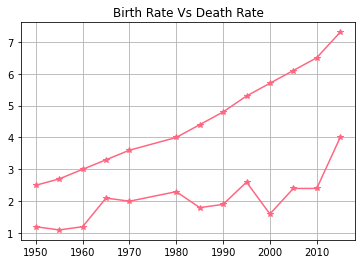

In [28]:
%matplotlib inline
lines=plt.plot(task_params['years'],task_params['birth'],task_params['years'],task_params['death'])
plt.grid(True)
plt.setp(lines,color=(1,.4,.5),marker='*')
plt.title('Birth Rate Vs Death Rate')
plt.show()

### Visualizing the updated data in the server.
  ![image11](images/plot1.png "withvswothput_light")  

## Plot-2 

In [25]:
task_params['num_scatter_samples']= 500
task_params['sin_max_value']= 20
task_params['sin_steps'] = 60

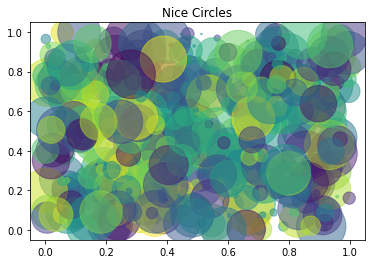

In [27]:
N = task_params['num_scatter_samples']
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (50 * np.random.rand(N))**2  # 0 to 15 point radii
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title('Nice Circles')
plt.show()


##### Observation: Updating the task_params is traced and updated in ClearML

## Keras Training Example

In [29]:
task_params['batch_size'] = 128
task_params['nb_classes'] = 10
task_params['nb_epoch'] = 6
task_params['hidden_dim'] = 512
batch_size = task_params['batch_size']
nb_classes = task_params['nb_classes']
nb_epoch = task_params['nb_epoch']

In [31]:
# Load data
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

60000 train samples
10000 test samples


In [36]:
# Defining Model
hidden_dim = task_params['hidden_dim']

model = Sequential()
model.add(Dense(hidden_dim, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(hidden_dim))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

### Configuring the Logs

Here the model logs, and checkpoint saving paths are assigned to a temp directory. And clearMl tracks that directory.  

In [38]:
board = TensorBoard(histogram_freq=1, log_dir=os.path.join(tempfile.gettempdir(), 'histogram_example'))

model_store = ModelCheckpoint(filepath=os.path.join(tempfile.gettempdir(), 'weight.{epoch}.hdf5'), 
                              save_freq=36000)

In [39]:
model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    callbacks=[board, model_store],
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/6
469/469 [==============================] - 2s 3ms/step - loss: 0.2454 - accuracy: 0.9239 - val_loss: 0.1090 - val_accuracy: 0.9643
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1017 - accuracy: 0.9686 - val_loss: 0.0819 - val_accuracy: 0.9761
Epoch 3/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0750 - accuracy: 0.9775 - val_loss: 0.0870 - val_accuracy: 0.9747
Epoch 4/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0608 - accuracy: 0.9821 - val_loss: 0.0762 - val_accuracy: 0.9798
Epoch 5/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0488 - accuracy: 0.9848 - val_loss: 0.0787 - val_accuracy: 0.9796
Epoch 6/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0432 - accuracy: 0.9872 - val_loss: 0.0929 - val_accuracy: 0.9774
Test score: 0.09293535351753235
Test accuracy: 0.977400004863739
2022-02-08 10:30:58,000 - clearml.Task - WARNING - ### TASK STOPPED - USER ABORTED - STAT

The clearML automatically tracks the log and plots and models due to that in the above code snippet, nowhere we can see any parameter related to clearML. 

**Console Output**

![image11](images/plot2.png "keras_model")  

**Scalars**

![image11](images/plot3.png "keras_model")  

**Configuration** these are the same parameters that we have defined using task_params. This configuration parameters helps us to spin the new training remotely.

![image11](images/plot4.png "keras_model")  
